In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn import preprocessing
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [2]:
df_titanic = sns.load_dataset('titanic')
df = df_titanic.copy()


In [3]:
def is_null(df):
    null = df.isnull().sum().sort_values()
    fig, ax = plt.subplots()
    plt.bar(null.index, null)
    plt.xticks(rotation = 90)
    plt.show()


In [4]:
def create_dummy_variables(variables, data):
    df = data.copy()
    for v in variables:
        temp = pd.get_dummies(df[v], drop_first = True)
        df = df.drop(columns = v, axis = 0)
        df = df.join(temp)
    return df


 Classification report for linear regression

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       125
           1       0.77      0.73      0.75        89

    accuracy                           0.80       214
   macro avg       0.79      0.79      0.79       214
weighted avg       0.80      0.80      0.80       214


 Classification report for logistic regression

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       125
           1       0.78      0.70      0.73        89

    accuracy                           0.79       214
   macro avg       0.79      0.78      0.78       214
weighted avg       0.79      0.79      0.79       214



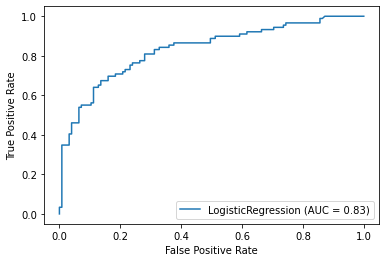

The comparison of the metrics suggests that the performance of the logistic regression and linear regression after rounding the estimated values are similar.


In [19]:
#Cleaning dataframe
df = df_titanic.copy()

#Remove redundant columns : class, who, adult_male, embark_town, alone
rm_cols = ['class', 'who', 'adult_male', 'embark_town', 'alone', 'alive']
df = df.drop(columns = rm_cols, axis = 1)

#Fill na in deck
df['deck'] = df['deck'].astype('string').fillna('unknown')

#Remove na in age and embarked
df = df.dropna(axis = 0, how = 'any', subset = ['age', 'embarked'])

#Encode column sex with 1 and 0
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

#Create dummy variable
vars_to_dummy = ['pclass', 'embarked', 'deck']
df = create_dummy_variables(vars_to_dummy, df)

X = df.drop('survived', axis = 1)
y = df[['survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
temp = pd.DataFrame(y_pred)
temp = temp.applymap(round)
y_pred = np.array(temp.iloc[:,0])

print('\n Classification report for linear regression\n')
print(classification_report(y_test, y_pred))


#logistic regression

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)

print('\n Classification report for logistic regression\n')
print(classification_report(y_test, y_pred))
plot_roc_curve(logreg,X_test_scaled, y_test )
plt.show()
print("The comparison of the metrics suggests that the performance of the logistic regression and linear regression after rounding \
the estimated values are similar.")

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [6]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)


In [7]:
X = X.copy()
y = y.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg_model = LogisticRegression(max_iter = 1000)
logreg_model.fit(X_train_scaled, y_train)
y_pred = logreg_model.predict(X_test_scaled)

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1035
           1       0.94      0.97      0.96      1205
           2       0.90      0.89      0.89      1019
           3       0.90      0.89      0.89      1081
           4       0.92      0.93      0.92       968
           5       0.88      0.87      0.87       970
           6       0.92      0.94      0.93      1009
           7       0.92      0.94      0.93      1110
           8       0.89      0.85      0.87      1016
           9       0.91      0.91      0.91      1087

    accuracy                           0.92     10500
   macro avg       0.91      0.91      0.91     10500
weighted avg       0.92      0.92      0.92     10500



# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

Optimization terminated successfully.
         Current function value: 2.464426
         Iterations 8

The expected number of fish that will be caught by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables is around 2. The probability of catching 1 or more fish according to the Poisson distribution is 86%.

The poisson regression results suggest that a greater number of person in a group, using live bait and a camper is positively      correlated to fish count. It seems that the number of children is negatively correlated to fish count.

                          Poisson Regression Results                          
Dep. Variable:             FISH_COUNT   No. Observations:                  248
Model:                        Poisson   Df Residuals:                      243
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Feb 2021   Pseudo R-squ.:                  0.4224
Time:                   

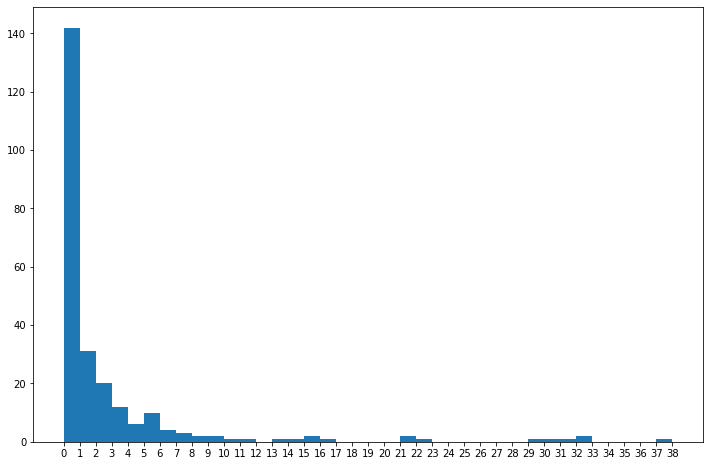

In [18]:
df = pd.read_csv('data/fish.csv')
df = df.copy()

#Rows with fish count beyond more than 3 times the standard deviation were removed since they were considered as outliers. 
max_fish = 39
df = df[df.FISH_COUNT < max_fish]

fig, ax = plt.subplots(figsize = (12,8))
plt.hist(df.FISH_COUNT, bins = max(df['FISH_COUNT']))
ax.set_xticks(np.arange(max_fish))

X = df.drop(['FISH_COUNT'] , axis = 1)
y = df['FISH_COUNT']
est = sm.Poisson(y, sm.add_constant(X)).fit(cov_type = 'HC2')

mean = np.floor(np.mean(df.FISH_COUNT))
prob_0_fish = np.exp(-mean)*mean**0/1
prob_1_fish_plus = 1 - prob_0_fish

#Results

print(f'\nThe expected number of fish that will be caught by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS\
 and CHILDREN variables is around 2. The probability of catching 1 or more fish according to the Poisson distribution\
 is {round(prob_1_fish_plus*100)}%.\n')

print('The poisson regression results suggest that a greater number of person in a group, using live bait and a camper is positively\
      correlated to fish count. It seems that the number of children is negatively correlated to fish count.\n')
print(est.summary())

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [10]:
df = pd.read_csv('data/telco_churn.csv')
df = df.copy()


In [11]:
cols = df.columns
for c in cols:
    print(f'{c} : {df[c].unique()}')

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank tr

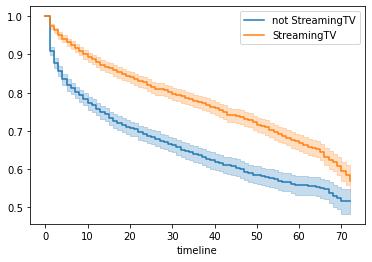

In [12]:
#5.1 Subscribed to StreamingTV vs not subscribed to StreamingTV
df = pd.read_csv('data/telco_churn.csv')
df = df.copy()

df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df['StreamingTV'] = df['StreamingTV'].map({'Yes':1, 'No':0})
X = df[['tenure', 'Churn', 'StreamingTV']].dropna()
filter_stv = X['StreamingTV'] == 0

kmf = KaplanMeierFitter()

kmf.fit(X[filter_stv].tenure, X.loc[filter_stv]['Churn'], label='not StreamingTV')
kmf.plot_survival_function()

kmf.fit(X.loc[~filter_stv].tenure, X.loc[~filter_stv]['Churn'], label='StreamingTV')
kmf.plot_survival_function()
plt.show()


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12661.24
         time fit was run = 2021-02-13 02:06:01 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender                                  0.04       1.04       0.05            -0.05             0.13                 0.95                 1.14
SeniorCitizen                           0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
Partner                                -0.18       0.84       0.06            -0.28            -0.07                 0.75                 0.93
Dependents                             -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
PhoneService                            0.03       1.03       0.14            -0.25             0.31                 0.78                 1.37
MultipleLines                          -0.11       0.89       0.06            -0.22            -0.00                 0.80                 1.00
InternetService                         1.34       3.83       0.18             0.98             1.70                 2.67                 5.48
OnlineSecurity                         -0.42       0.66       0.07            -0.55            -0.28                 0.58                 0.75
OnlineBackup                           -0.26       0.77       0.06            -0.37            -0.15                 0.69                 0.86
DeviceProtection                       -0.11       0.89       0.06            -0.22            -0.00                 0.80                 1.00
TechSupport                            -0.29       0.75       0.07            -0.42            -0.16                 0.66                 0.85
StreamingTV                            -0.12       0.89       0.06            -0.24             0.00                 0.79                 1.00
StreamingMovies                        -0.11       0.89       0.06            -0.23             0.01                 0.79                 1.01
PaperlessBilling                        0.15       1.17       0.06             0.04             0.26                 1.04                 1.30
MonthlyCharges                          0.05       1.05       0.00             0.05             0.06                 1.05                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Contract_One year                      -1.27       0.28       0.10            -1.47            -1.07                 0.23                 0.34
Contract_Two year                      -3.71       0.02       0.20            -4.10            -3.31                 0.02                 0.04
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.27                 1.70
PaymentMethod_Mailed check              0.51       1.66       0.09             0.34             0.68                 1.40                 1.97

                                           z      p   -log2(p)
covariate                                                     
gender                                  0.93   0.35       1.51
SeniorCitizen                           0.66   0.51       0.97
Partner                                -3.21 <0.005       9.56
Dependents                    

None


<AxesSubplot:xlabel='log(HR) (95% CI)'>

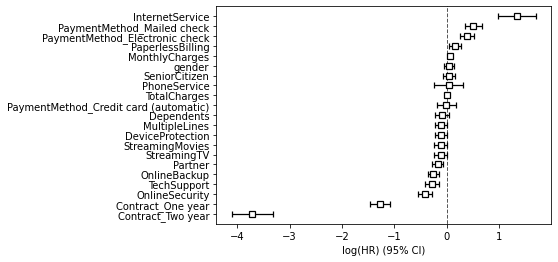

In [13]:
#5.2 Use either lifelines or statsmodels to implement a survival regression model predicting tenure. 
#Don't forget to use the churn column as the event column.

df = pd.read_csv('data/telco_churn.csv')
df = df.copy()

#Change to numerical value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

#Encode as 1's and 0's
yes_no_variables = ['Partner', 
                    'Dependents', 
                    'PhoneService', 
                    'PaperlessBilling', 
                    'Churn']

for v in yes_no_variables:
    df[v] = df[v].map({'Yes': 1, 'No': 0})   
    
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

#Convert No and No service as 0's and Yes as 1's
var_to_yes_no = ['MultipleLines',
                'InternetService',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies']

for v in var_to_yes_no:
    df[v]= df[v].str.contains('No').map({False: 1, True : 0})

#Convert to dummy variables
categories = ['Contract', 'PaymentMethod']

for c in categories:
    temp = pd.get_dummies(df[c], drop_first = True, prefix = c )
    df = df.join(temp)
    df = df.drop(c, axis = 1)

df = df.drop('customerID', axis = 1)
df = df.dropna()

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col = 'tenure', event_col='Churn')
print(cph.print_summary())
cph.plot()